# ControlNet으로 조건을 준 이미지 생성하기

In [2]:
# Stable Diffusion 설치
!pip install -qq diffusers==0.31

# 윤곽선 검출

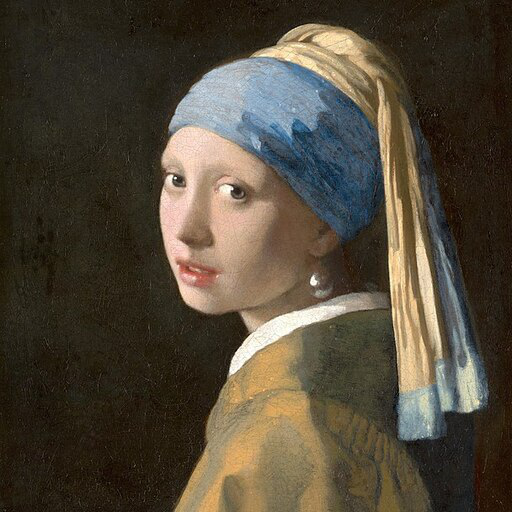

In [3]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

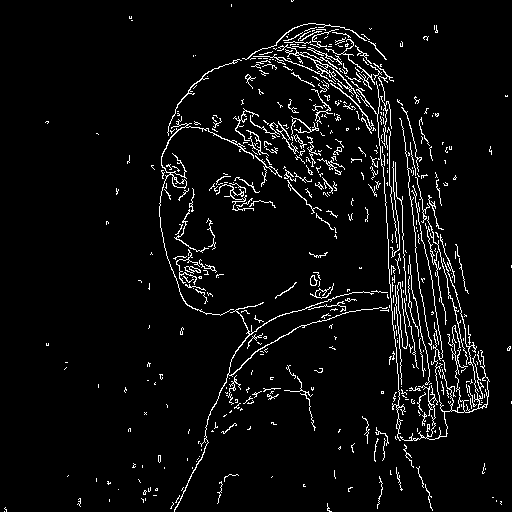

In [4]:
import cv2
from PIL import Image
import numpy as np

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# threshold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다.
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다.

canny_image

In [5]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

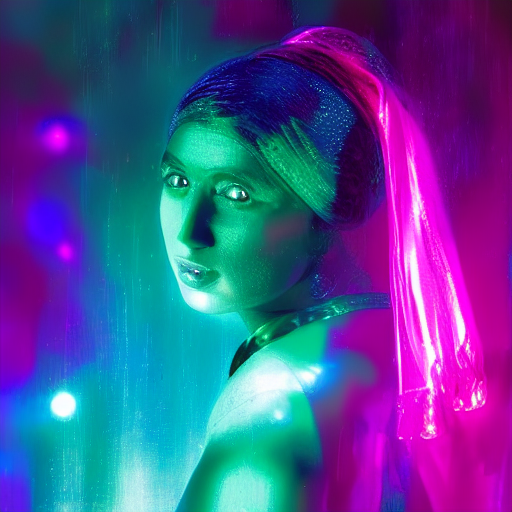

In [6]:
from diffusers import UniPCMultistepScheduler
canny_pipe = canny_pipe.to("cuda")
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=20,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 출력합니다.
canny_image

  0%|          | 0/50 [00:00<?, ?it/s]

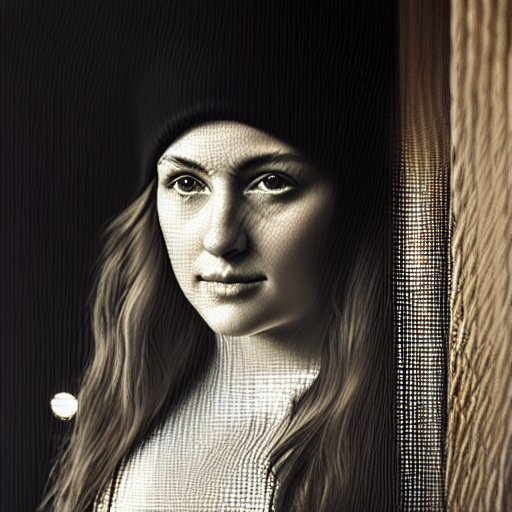

In [7]:
# 프롬프트와 부정 프롬프트 설정
prompt = "Masterpiece oil painting portrait of a person in the style of Rembrandt, dramatic chiaroscuro lighting, highly detailed face, intricate clothing texture, rich colors, high quality"
negative_prompt = "ugly, deformed, disfigured, malformed, distorted, blurry, low quality, low resolution, noisy, cluttered, text, watermark, signature, username, artist name, extra limbs, missing limbs, bad anatomy, poorly drawn face, poorly drawn hands, extra fingers, missing fingers, mutated hands, error, artifacts, bad proportions, disconnected limbs, duplicate, photo, photograph, modern clothing, simplistic, flat shading, weak outline, cartoon, illustration"

# 하이퍼파라미터 설정
num_inference_steps = 50
guidance_scale = 9.0
controlnet_conditioning_scale = 1.0

# 동일한 seed를 사용
generator = torch.manual_seed(0)

# 이미지 생성
generated_image = canny_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=canny_image,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    generator=generator
).images[0]

# 생성된 이미지 출력
generated_image

## 포즈 검출

In [8]:
!pip install controlnet-aux==0.0.1

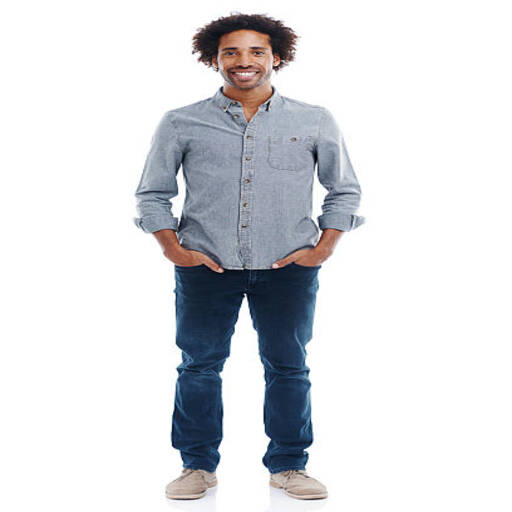

In [9]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

cuda


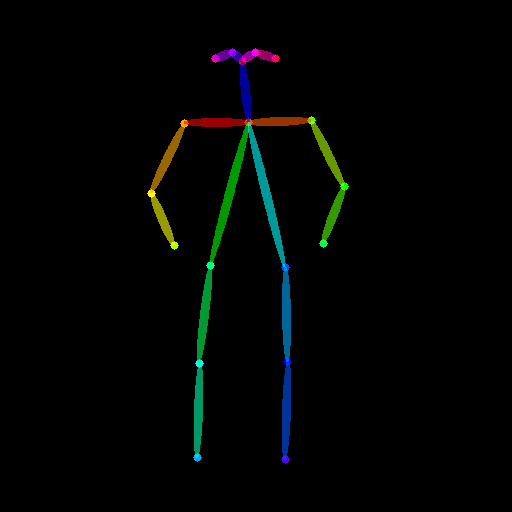

In [10]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [11]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

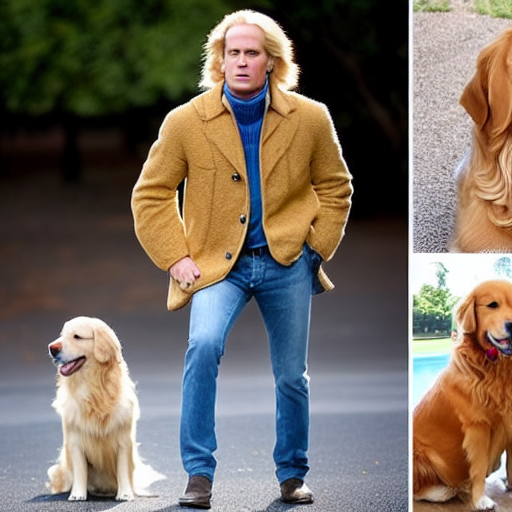

In [12]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다.
generator = torch.manual_seed(0)

#프롬프트를 작성합니다.
prompt = "Golden retriever dog trying to mimic the human pose, park setting, slightly confused expression, realistic style"
negative_prompt = "human, person, man, woman, face, skin, blurry, low quality, extra limbs, bad anatomy, deformed, text, watermark, cropped, out of frame, ugly, disfigured, mutated paws, distorted snout, worst quality, low resolution"

openpose_image1 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=openpose_image, # OpenPose Detector가 생성한 포즈 이미지를 입력
    generator=generator,
    num_inference_steps=50,
    guidance_scale=9.0
).images[0]

# 생성된 이미지를 출력합니다.
openpose_image1

## 윤곽선 검출 + 인체 자세 감지

In [13]:
from diffusers.utils import load_image
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# 1. Canny Edge 이미지 생성
# 이미 불러온 이미지 URL을 재사용 (사이즈 맞춤)
base_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
).resize((512, 512))

# OpenCV로 변환
canny_np = np.array(base_image)
canny_edges = cv2.Canny(canny_np, 100, 200)

# 중앙 영역 제거
zero_start = canny_edges.shape[1] // 4
zero_end = zero_start + canny_edges.shape[1] // 2
canny_edges[:, zero_start:zero_end] = 0

# PIL 이미지로 변환
canny_image = Image.fromarray(canny_edges).convert("RGB")

# 2. Canny ControlNet 모델 로드
canny_controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16
)

In [14]:
# 3. 두 개의 ControlNet을 리스트로 연결
controlnets = [openpose_controlnet, canny_controlnet]

# 4. 새로운 파이프라인 정의 (멀티 ControlNet)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 5. 동일 프롬프트/씨드 재사용
generator = torch.manual_seed(0)
prompt = "Golden retriever dog trying to mimic the human pose, park setting, slightly confused expression, realistic style"
negative_prompt = "human, person, man, woman, face, skin, blurry, low quality, extra limbs, bad anatomy, deformed, text, watermark, cropped, out of frame, ugly, disfigured, mutated paws, distorted snout, worst quality, low resolution"

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

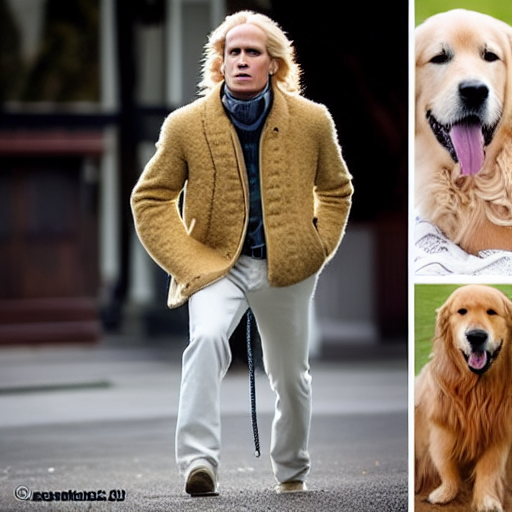

In [15]:
# 6. 이미지 생성 (OpenPose + Canny 둘 다 사용)
final_image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=[openpose_image, canny_image],
    generator=generator,
    num_inference_steps=50,
    guidance_scale=9.0
).images[0]

# 7. 출력
final_image.save("multi_controlnet_result.png")
final_image